In [1]:
from unityagents import UnityEnvironment
env_file = 'Tennis_Linux/Tennis.x86_64'# "Tennis_Windows_x86_64\Tennis.exe" #
env = UnityEnvironment(file_name=env_file, no_graphics = True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
import random
import sys
import torch
import numpy as np
from collections import deque
import progressbar as pb
import matplotlib.pyplot as plt
from utils import OUprocess, Reply_buffer
from Tennis_agent import SelfPlay_Agent

using device:  cuda:0
NO grad. clipping used.


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('states shape: ',states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
states shape:  (2, 24)
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


In [4]:
def train_agent(env, nr_episodes, num_agents, seed): 
    
    max_buffer = int(1.e+6)
    
    noise_decay = 1#0.999
    noise_lvl = 0.2
    
    batch_size = 256
    update_steps = 5
    GD_steps = 4
    lra=1.e-3
    lrc=1.e-3
    tau=1
    discount=0.999
    
    print('### ===================================== seed {} ======================================= ###'.format(seed))
    print('lra {}, lrc {}, noise_lvl {}, noise_decay {}, batch_size {}, update_steps {}, GD_steps {}, tau {}, gamma {}'.format(
        lra, lrc, noise_lvl,noise_decay,batch_size,update_steps,GD_steps,tau,discount))
    
    buffer = Reply_buffer(max_buffer,seed=seed)
    ou = OUprocess(num_agents, action_size, sigma=noise_lvl, seed=seed)
    agent = SelfPlay_Agent(state_size, action_size, num_agents, tau=tau, discount=discount, lr_act=lra, lr_crit=lrc, seed=seed)
    print(agent.actor)
    print(agent.critic)
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar()]
    timer = pb.ProgressBar(widgets=widget, maxval=nr_episodes).start()
    ACloss = []
    l_exists = False
    max_avg = np.inf
    e_score = np.zeros(nr_episodes)
    rolling_avg = np.zeros(nr_episodes)
    rolling_window = deque(maxlen=100)
    t=0
    for i in range(nr_episodes):                                         # play game for nr_episodes episodes
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        ou.reset()
    #     ouB.reset()
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            t+=1
            # select action
            agent.actor.eval()
            noise = ou.noise()
            actA  = agent.act(states[np.newaxis,0]).data.cpu().numpy() + noise[0]
            actB = agent.act(states[np.newaxis,1]).data.cpu().numpy() + noise[1]
            actions = np.clip([actA[0], actB[0]],-1,1) # select an action (for each agent)
            # execute and observe
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            # store in replay buffer
            samples = [states, np.asarray(actions), np.asarray(rewards), next_states, dones]
            buffer.store(samples)
            # roll over states to next time step
            states = next_states                               
            # keep track of scores
            scores += env_info.rewards                         # update the score (for each agent)
            # Update agents
            if ((t-1) % update_steps == 0) and len(buffer.buffer) > batch_size:
                l_exists = True
                agent.actor.train()
                for ep in range(GD_steps):
                    minibatch = buffer.get_batch(batch_size)  # get batch of size (batch_size x 5) where the 2nd dim corresponds to (s,a,r,s',done)
                    agent_i = np.random.choice(num_agents,len(minibatch))
                    closs = agent.update_critic(minibatch,agent_i)
                    aloss = agent.update_actor(minibatch,agent_i)

            # Update target network
            if agent.tau == 1 and t% int(2*update_steps) == 0:
                agent.target_update()
            else:
                agent.target_update()
            # exit loop if episode finished
            if np.any(dones): 
                break

        if l_exists:
            ACloss.append([aloss,closs])

        ou.sigma *= noise_decay

        e_score[i] = np.max(scores)
        rolling_window.append(e_score[i])
        rolling_avg[i] = np.mean(np.array(rolling_window))
        if rolling_avg[i] > 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i, rolling_avg[i]))
            # Save actor and critic
            torch.save(agent.actor.state_dict(), 'Tennis.player')
            torch.save(agent.critic.state_dict(), 'Tennis.critic')
            max_avg = rolling_avg[i]
            print('Networks saved')

        if (i+1) % 20 == 0:
            print('Total score (averaged over agents) episode {}: {}'.format(i+1,np.mean(scores)))
            print('Score (max over agents) from episode {}: {}'.format(i+1, e_score[i]))
            print('Rolling average score: {}'.format(rolling_avg[i]))
    #         print('Noise level: ',ouA.sigma,ouB.sigma)
            if l_exists:
                print("Actor loss: {} | Critic loss: {}".format(*ACloss[-1]))
            if rolling_avg[i]>max_avg:
                # Save best actor and critic
                torch.save(agent.actor.state_dict(), 'Tennis.player')
                torch.save(agent.critic.state_dict(), 'Tennis.critic')
                max_avg = rolling_avg[i]
                print('Better network saved!')
        # update progress widget bar
        timer.update(i+1)

    print('Max score: ', rolling_avg.max())
    timer.finish()
    
    print('### ---------------------------- ++++++++++++++++++++++++ ---------------------------- ###')
    ACloss = np.asarray(ACloss)
    return ACloss, rolling_avg, e_score, agent

### ===================================== seed 2766530 ======================================= ###
lra 0.001, lrc 0.001, noise_lvl 0.2, noise_decay 1, batch_size 256, update_steps 5, GD_steps 4, tau 1, gamma 0.999
Random seed in buffer is:  2766530
numpy seed in ou-process set to : 2766530
torch seed in actor set to:  2766530


torch seed in actor set to:  2766530
torch seed in critic set to:  2766530
torch seed in critic set to:  2766530
ActorNet(
  (fc_in): Linear(in_features=24, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=2, bias=True)
)
CriticNet(
  (bn0): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_in): Linear(in_features=52, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)


Total score (averaged over agents) episode 20: -0.004999999888241291
Score (max over agents) from episode 20: 0.0
Rolling average score: 0.005000000074505806
Actor loss: -0.01859528385102749 | Critic loss: 0.00026308270753361285


Total score (averaged over agents) episode 40: -0.004999999888241291
Score (max over agents) from episode 40: 0.0
Rolling average score: 0.002500000037252903
Actor loss: -0.10647831857204437 | Critic loss: 0.0020669796504080296


Total score (averaged over agents) episode 60: -0.004999999888241291
Score (max over agents) from episode 60: 0.0
Rolling average score: 0.0031666667200624943
Actor loss: -0.009820601902902126 | Critic loss: 0.00029592870851047337


Total score (averaged over agents) episode 80: -0.004999999888241291
Score (max over agents) from episode 80: 0.0
Rolling average score: 0.0023750000400468707
Actor loss: -0.004502888768911362 | Critic loss: 7.424222712870687e-05


Total score (averaged over agents) episode 100: -0.004999999888241291
Score (max over agents) from episode 100: 0.0
Rolling average score: 0.0019000000320374966
Actor loss: 0.0003918083384633064 | Critic loss: 6.0206777561688796e-05


Total score (averaged over agents) episode 120: -0.004999999888241291
Score (max over agents) from episode 120: 0.0
Rolling average score: 0.0009000000171363354
Actor loss: -0.00182892638258636 | Critic loss: 1.603530654392671e-05


Total score (averaged over agents) episode 140: -0.004999999888241291
Score (max over agents) from episode 140: 0.0
Rolling average score: 0.0009000000171363354
Actor loss: -0.0026486588176339865 | Critic loss: 2.0221314116497524e-05


Total score (averaged over agents) episode 160: -0.004999999888241291
Score (max over agents) from episode 160: 0.0
Rolling average score: 0.0
Actor loss: -0.00394014548510313 | Critic loss: 1.693783633527346e-05


Total score (averaged over agents) episode 180: 0.04500000085681677
Score (max over agents) from episode 180: 0.10000000149011612
Rolling average score: 0.005800000093877315
Actor loss: -0.004971832036972046 | Critic loss: 3.490562448860146e-05


Total score (averaged over agents) episode 200: -0.004999999888241291
Score (max over agents) from episode 200: 0.0
Rolling average score: 0.006700000111013651
Actor loss: -0.0021235537715256214 | Critic loss: 3.1449755624635145e-05


Total score (averaged over agents) episode 220: 0.24000000394880772
Score (max over agents) from episode 220: 0.30000000447034836
Rolling average score: 0.011700000185519456
Actor loss: -0.012047234922647476 | Critic loss: 4.143708065384999e-05


Total score (averaged over agents) episode 240: -0.004999999888241291
Score (max over agents) from episode 240: 0.0
Rolling average score: 0.015600000247359276
Actor loss: -0.022219926118850708 | Critic loss: 0.00010725437459768727


Total score (averaged over agents) episode 260: -0.004999999888241291
Score (max over agents) from episode 260: 0.0
Rolling average score: 0.02250000035390258
Actor loss: -0.032810479402542114 | Critic loss: 0.00019168575818184763


Total score (averaged over agents) episode 280: -0.004999999888241291
Score (max over agents) from episode 280: 0.0
Rolling average score: 0.02250000035390258
Actor loss: -0.050242118537425995 | Critic loss: 0.00024769629817456007


Total score (averaged over agents) episode 300: -0.004999999888241291
Score (max over agents) from episode 300: 0.0
Rolling average score: 0.03320000052452087
Actor loss: -0.03720258176326752 | Critic loss: 0.00019394035916775465


Total score (averaged over agents) episode 320: -0.004999999888241291
Score (max over agents) from episode 320: 0.0
Rolling average score: 0.03770000061020255
Actor loss: -0.06864939630031586 | Critic loss: 0.0002505165175534785


Total score (averaged over agents) episode 340: 0.04500000085681677
Score (max over agents) from episode 340: 0.10000000149011612
Rolling average score: 0.049500000793486834
Actor loss: -0.19307072460651398 | Critic loss: 0.0005572625086642802


Total score (averaged over agents) episode 360: 0.04500000085681677
Score (max over agents) from episode 360: 0.10000000149011612
Rolling average score: 0.07740000123158097
Actor loss: -0.4053558111190796 | Critic loss: 0.003406747244298458


Total score (averaged over agents) episode 380: 0.04500000085681677
Score (max over agents) from episode 380: 0.10000000149011612
Rolling average score: 0.09540000149980188
Actor loss: -0.3651379942893982 | Critic loss: 0.0030366911087185144


Total score (averaged over agents) episode 400: 0.3950000060722232
Score (max over agents) from episode 400: 0.4000000059604645
Rolling average score: 0.12670000195503234
Actor loss: -0.4504058361053467 | Critic loss: 0.0036408943124115467


Total score (averaged over agents) episode 420: 0.04500000085681677
Score (max over agents) from episode 420: 0.10000000149011612
Rolling average score: 0.16000000244006515
Actor loss: -0.5924396514892578 | Critic loss: 0.005802717059850693


Total score (averaged over agents) episode 440: 0.8950000135228038
Score (max over agents) from episode 440: 0.9000000134110451
Rolling average score: 0.18880000287666918
Actor loss: -0.6495146751403809 | Critic loss: 0.0028930159751325846


Total score (averaged over agents) episode 460: 0.09500000160187483
Score (max over agents) from episode 460: 0.10000000149011612
Rolling average score: 0.19400000292807817
Actor loss: -0.7945457696914673 | Critic loss: 0.008292723447084427


Total score (averaged over agents) episode 480: 0.09500000160187483
Score (max over agents) from episode 480: 0.10000000149011612
Rolling average score: 0.21500000324100255
Actor loss: -0.8003724813461304 | Critic loss: 0.006471723318099976


Total score (averaged over agents) episode 500: 0.1450000023469329
Score (max over agents) from episode 500: 0.20000000298023224
Rolling average score: 0.24280000366270543
Actor loss: -1.3306792974472046 | Critic loss: 0.012121936306357384


Total score (averaged over agents) episode 520: 0.19500000309199095
Score (max over agents) from episode 520: 0.20000000298023224
Rolling average score: 0.23690000357106328
Actor loss: -1.7615413665771484 | Critic loss: 0.013114717788994312


Total score (averaged over agents) episode 540: 0.3950000060722232
Score (max over agents) from episode 540: 0.4000000059604645
Rolling average score: 0.24740000370889903
Actor loss: -1.798406720161438 | Critic loss: 0.011043664067983627


Total score (averaged over agents) episode 560: 0.3450000053271651
Score (max over agents) from episode 560: 0.4000000059604645
Rolling average score: 0.2612000039219856
Actor loss: -1.968902826309204 | Critic loss: 0.01948966644704342


Total score (averaged over agents) episode 580: 0.39500000700354576
Score (max over agents) from episode 580: 0.4000000059604645
Rolling average score: 0.2574000038579106
Actor loss: -2.8903651237487793 | Critic loss: 0.06677974760532379


Total score (averaged over agents) episode 600: 0.245000003837049
Score (max over agents) from episode 600: 0.30000000447034836
Rolling average score: 0.24070000359788538
Actor loss: -4.42433500289917 | Critic loss: 0.11299826949834824


Total score (averaged over agents) episode 620: 0.44500000681728125
Score (max over agents) from episode 620: 0.5000000074505806
Rolling average score: 0.2557000038214028
Actor loss: -7.234282970428467 | Critic loss: 0.24235466122627258


Total score (averaged over agents) episode 640: 0.29500000458210707
Score (max over agents) from episode 640: 0.4000000059604645
Rolling average score: 0.2536000037938356
Actor loss: -15.251422882080078 | Critic loss: 1.171426773071289


Total score (averaged over agents) episode 660: -0.004999999888241291
Score (max over agents) from episode 660: 0.0
Rolling average score: 0.23840000357478858
Actor loss: -21.930139541625977 | Critic loss: 2.6556968688964844


Total score (averaged over agents) episode 680: 0.19500000309199095
Score (max over agents) from episode 680: 0.20000000298023224
Rolling average score: 0.24740000370889903
Actor loss: -31.82274627685547 | Critic loss: 6.950283050537109


Total score (averaged over agents) episode 700: 0.1450000023469329
Score (max over agents) from episode 700: 0.20000000298023224
Rolling average score: 0.2274000034108758
Actor loss: -48.89806365966797 | Critic loss: 18.98332977294922


Total score (averaged over agents) episode 720: -0.004999999888241291
Score (max over agents) from episode 720: 0.0
Rolling average score: 0.23720000356435775
Actor loss: -89.02734375 | Critic loss: 39.209293365478516


Total score (averaged over agents) episode 740: 0.4950000075623393
Score (max over agents) from episode 740: 0.5000000074505806
Rolling average score: 0.24830000372603536
Actor loss: -190.1173858642578 | Critic loss: 133.91485595703125


Total score (averaged over agents) episode 760: -0.004999999888241291
Score (max over agents) from episode 760: 0.0
Rolling average score: 0.2585000038892031
Actor loss: -384.9918212890625 | Critic loss: 583.401123046875


Total score (averaged over agents) episode 780: 0.09500000160187483
Score (max over agents) from episode 780: 0.10000000149011612
Rolling average score: 0.25430000383406876
Actor loss: -731.3021240234375 | Critic loss: 1895.6866455078125


Total score (averaged over agents) episode 800: 0.09500000160187483
Score (max over agents) from episode 800: 0.10000000149011612
Rolling average score: 0.26720000403001903
Actor loss: -1322.801025390625 | Critic loss: 8091.951171875


Total score (averaged over agents) episode 820: 0.09500000160187483
Score (max over agents) from episode 820: 0.10000000149011612
Rolling average score: 0.27350000411272046
Actor loss: -3125.416748046875 | Critic loss: 27167.7890625


Total score (averaged over agents) episode 840: 0.1450000023469329
Score (max over agents) from episode 840: 0.20000000298023224
Rolling average score: 0.2535000038146973
Actor loss: -4306.9560546875 | Critic loss: 81355.03125


Total score (averaged over agents) episode 860: 0.1450000023469329
Score (max over agents) from episode 860: 0.20000000298023224
Rolling average score: 0.2456000036932528
Actor loss: -6148.09765625 | Critic loss: 301736.0625


Total score (averaged over agents) episode 880: -0.004999999888241291
Score (max over agents) from episode 880: 0.0
Rolling average score: 0.24270000364631414
Actor loss: -8960.78515625 | Critic loss: 383228.84375


Total score (averaged over agents) episode 900: -0.004999999888241291
Score (max over agents) from episode 900: 0.0
Rolling average score: 0.22970000345259906
Actor loss: -11651.013671875 | Critic loss: 379531.4375


Total score (averaged over agents) episode 920: -0.004999999888241291
Score (max over agents) from episode 920: 0.0
Rolling average score: 0.22150000335648656
Actor loss: -18525.345703125 | Critic loss: 1353991.5


Total score (averaged over agents) episode 940: -0.004999999888241291
Score (max over agents) from episode 940: 0.0
Rolling average score: 0.20840000316500665
Actor loss: -24757.84765625 | Critic loss: 2116811.25


Total score (averaged over agents) episode 960: 0.09500000160187483
Score (max over agents) from episode 960: 0.10000000149011612
Rolling average score: 0.23350000351667405
Actor loss: -47838.765625 | Critic loss: 13834908.0


Total score (averaged over agents) episode 980: 1.5450000232085586
Score (max over agents) from episode 980: 1.600000023841858
Rolling average score: 0.2946000044234097
Actor loss: -126518.25 | Critic loss: 107264184.0


Total score (averaged over agents) episode 1000: 0.04500000085681677
Score (max over agents) from episode 1000: 0.10000000149011612
Rolling average score: 0.3027000045403838
Actor loss: -199778.40625 | Critic loss: 192083984.0


Total score (averaged over agents) episode 1020: 0.9950000150129199
Score (max over agents) from episode 1020: 1.0000000149011612
Rolling average score: 0.3008000044897199
Actor loss: -338604.5 | Critic loss: 306220992.0


Total score (averaged over agents) episode 1040: 0.19500000309199095
Score (max over agents) from episode 1040: 0.20000000298023224
Rolling average score: 0.31490000469610097
Actor loss: -529646.5 | Critic loss: 775752576.0


Total score (averaged over agents) episode 1060: 0.04500000085681677
Score (max over agents) from episode 1060: 0.10000000149011612
Rolling average score: 0.2847000042535365
Actor loss: -759095.625 | Critic loss: 1809333248.0


Total score (averaged over agents) episode 1080: 0.04500000085681677
Score (max over agents) from episode 1080: 0.10000000149011612
Rolling average score: 0.22350000334903597
Actor loss: -1018763.0625 | Critic loss: 5062398976.0


Total score (averaged over agents) episode 1100: 0.3450000053271651
Score (max over agents) from episode 1100: 0.3900000061839819
Rolling average score: 0.22310000335797667
Actor loss: -1229799.5 | Critic loss: 6743868416.0


Total score (averaged over agents) episode 1120: 0.04500000085681677
Score (max over agents) from episode 1120: 0.10000000149011612
Rolling average score: 0.19210000289604068
Actor loss: -1395712.0 | Critic loss: 8953814016.0


Total score (averaged over agents) episode 1140: 0.04500000085681677
Score (max over agents) from episode 1140: 0.09000000171363354
Rolling average score: 0.195700002964586
Actor loss: -1654115.25 | Critic loss: 7998184960.0


Total score (averaged over agents) episode 1160: 0.09500000160187483
Score (max over agents) from episode 1160: 0.10000000149011612
Rolling average score: 0.2148000032454729
Actor loss: -2024769.375 | Critic loss: 28330420224.0


Total score (averaged over agents) episode 1180: 0.245000003837049
Score (max over agents) from episode 1180: 0.30000000447034836
Rolling average score: 0.21490000324323774
Actor loss: -2440704.5 | Critic loss: 40326742016.0


Total score (averaged over agents) episode 1200: 0.09500000160187483
Score (max over agents) from episode 1200: 0.10000000149011612
Rolling average score: 0.2131000032275915
Actor loss: -2735222.75 | Critic loss: 46857576448.0


Total score (averaged over agents) episode 1220: 0.245000003837049
Score (max over agents) from episode 1220: 0.30000000447034836
Rolling average score: 0.25880000391975044
Actor loss: -3245121.25 | Critic loss: 32664547328.0


Total score (averaged over agents) episode 1240: 0.0950000025331974
Score (max over agents) from episode 1240: 0.10000000149011612
Rolling average score: 0.2490000037662685
Actor loss: -3659964.5 | Critic loss: 87221878784.0


Total score (averaged over agents) episode 1260: -0.004999999888241291
Score (max over agents) from episode 1260: 0.0
Rolling average score: 0.235900003593415
Actor loss: -4054530.0 | Critic loss: 78778089472.0


Total score (averaged over agents) episode 1280: 0.09500000160187483
Score (max over agents) from episode 1280: 0.10000000149011612
Rolling average score: 0.24090000366792083
Actor loss: -4757871.5 | Critic loss: 123823276032.0


Total score (averaged over agents) episode 1300: 0.29500000458210707
Score (max over agents) from episode 1300: 0.30000000447034836
Rolling average score: 0.26090000396594404
Actor loss: -5172587.0 | Critic loss: 91214069760.0


Total score (averaged over agents) episode 1320: -0.004999999888241291
Score (max over agents) from episode 1320: 0.0
Rolling average score: 0.22810000346973539
Actor loss: -5891205.0 | Critic loss: 166862307328.0


Total score (averaged over agents) episode 1340: 1.045000015757978
Score (max over agents) from episode 1340: 1.1000000163912773
Rolling average score: 0.26430000400170683
Actor loss: -7123657.0 | Critic loss: 348066447360.0


Total score (averaged over agents) episode 1360: 0.5450000083073974
Score (max over agents) from episode 1360: 0.6000000089406967
Rolling average score: 0.26640000401064756
Actor loss: -8034702.0 | Critic loss: 294689964032.0


Total score (averaged over agents) episode 1380: -0.004999999888241291
Score (max over agents) from episode 1380: 0.0
Rolling average score: 0.2794000042043626
Actor loss: -9159188.0 | Critic loss: 604017131520.0


Total score (averaged over agents) episode 1400: -0.004999999888241291
Score (max over agents) from episode 1400: 0.0
Rolling average score: 0.2754000041261315
Actor loss: -10589128.0 | Critic loss: 830687608832.0


Total score (averaged over agents) episode 1420: 0.19500000309199095
Score (max over agents) from episode 1420: 0.20000000298023224
Rolling average score: 0.31840000476688146
Actor loss: -12620283.0 | Critic loss: 501023506432.0


Total score (averaged over agents) episode 1440: 1.095000016503036
Score (max over agents) from episode 1440: 1.2000000178813934
Rolling average score: 0.31830000476911663
Actor loss: -14920981.0 | Critic loss: 1067353833472.0


Total score (averaged over agents) episode 1460: 0.44500000681728125
Score (max over agents) from episode 1460: 0.5000000074505806
Rolling average score: 0.3522000052779913
Actor loss: -17608586.0 | Critic loss: 2393265668096.0


Total score (averaged over agents) episode 1480: 0.09500000160187483
Score (max over agents) from episode 1480: 0.10000000149011612
Rolling average score: 0.35910000540316106
Actor loss: -20137626.0 | Critic loss: 2922847404032.0


training loop: 100% |#########################################################|


Total score (averaged over agents) episode 1500: 0.1450000023469329
Score (max over agents) from episode 1500: 0.20000000298023224
Rolling average score: 0.3592000054009259
Actor loss: -22375196.0 | Critic loss: 2044730408960.0
Max score:  0.36910000555217265
### ---------------------------- ++++++++++++++++++++++++ ---------------------------- ###
### ===================================== seed 8323110 ======================================= ###
lra 0.001, lrc 0.001, noise_lvl 0.2, noise_decay 1, batch_size 256, update_steps 5, GD_steps 4, tau 1, gamma 0.999
Random seed in buffer is:  8323110
numpy seed in ou-process set to : 8323110
torch seed in actor set to:  8323110
torch seed in actor set to:  8323110
torch seed in critic set to:  8323110
torch seed in critic set to:  8323110
ActorNet(
  (fc_in): Linear(in_features=24, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=2, bias=True)
)
CriticNet(

Total score (averaged over agents) episode 20: -0.004999999888241291
Score (max over agents) from episode 20: 0.0
Rolling average score: 0.009500000160187483
Actor loss: -0.017067130655050278 | Critic loss: 0.0001781401369953528


Total score (averaged over agents) episode 40: -0.004999999888241291
Score (max over agents) from episode 40: 0.0
Rolling average score: 0.004750000080093741
Actor loss: -0.011182304471731186 | Critic loss: 5.318860348779708e-05


Total score (averaged over agents) episode 60: -0.004999999888241291
Score (max over agents) from episode 60: 0.0
Rolling average score: 0.008000000131626923
Actor loss: -0.005352900363504887 | Critic loss: 3.3379896194674075e-05


Total score (averaged over agents) episode 80: -0.004999999888241291
Score (max over agents) from episode 80: 0.0
Rolling average score: 0.019500000309199093
Actor loss: -0.050262611359357834 | Critic loss: 0.0001554787450004369


Total score (averaged over agents) episode 100: 0.04500000085681677
Score (max over agents) from episode 100: 0.10000000149011612
Rolling average score: 0.030300000477582217
Actor loss: -0.07748193293809891 | Critic loss: 0.0002357625198783353


Total score (averaged over agents) episode 120: 0.1450000023469329
Score (max over agents) from episode 120: 0.20000000298023224
Rolling average score: 0.050000000800937416
Actor loss: -0.0896165668964386 | Critic loss: 0.0003523329505696893


Total score (averaged over agents) episode 140: -0.004999999888241291
Score (max over agents) from episode 140: 0.0
Rolling average score: 0.07550000119954348
Actor loss: -0.16742441058158875 | Critic loss: 0.0009863058803603053


Total score (averaged over agents) episode 160: 0.09500000160187483
Score (max over agents) from episode 160: 0.10000000149011612
Rolling average score: 0.10540000164881348
Actor loss: -0.379454106092453 | Critic loss: 0.0025585279799997807


Total score (averaged over agents) episode 180: 0.04500000085681677
Score (max over agents) from episode 180: 0.10000000149011612
Rolling average score: 0.12950000202283263
Actor loss: -0.5379282236099243 | Critic loss: 0.002910972572863102


Total score (averaged over agents) episode 200: 0.04500000085681677
Score (max over agents) from episode 200: 0.10000000149011612
Rolling average score: 0.1386000021547079
Actor loss: -0.6994694471359253 | Critic loss: 0.004512913525104523


Total score (averaged over agents) episode 220: 0.09500000160187483
Score (max over agents) from episode 220: 0.10000000149011612
Rolling average score: 0.15090000230818987
Actor loss: -1.04345703125 | Critic loss: 0.010681068524718285


Total score (averaged over agents) episode 240: 0.1450000023469329
Score (max over agents) from episode 240: 0.20000000298023224
Rolling average score: 0.14820000225678087
Actor loss: -0.9073834419250488 | Critic loss: 0.012095397338271141


Total score (averaged over agents) episode 260: 0.04500000085681677
Score (max over agents) from episode 260: 0.10000000149011612
Rolling average score: 0.15530000235885383
Actor loss: -0.8221031427383423 | Critic loss: 0.003771236864849925


Total score (averaged over agents) episode 280: 0.29500000458210707
Score (max over agents) from episode 280: 0.30000000447034836
Rolling average score: 0.1692000025510788
Actor loss: -0.9170491695404053 | Critic loss: 0.010250069200992584


Total score (averaged over agents) episode 300: 0.09500000160187483
Score (max over agents) from episode 300: 0.10000000149011612
Rolling average score: 0.18620000280439852
Actor loss: -1.09494149684906 | Critic loss: 0.010456852614879608


Total score (averaged over agents) episode 320: 0.1450000023469329
Score (max over agents) from episode 320: 0.20000000298023224
Rolling average score: 0.19320000290870668
Actor loss: -1.9399821758270264 | Critic loss: 0.03313539922237396


Total score (averaged over agents) episode 340: 0.19500000309199095
Score (max over agents) from episode 340: 0.20000000298023224
Rolling average score: 0.21420000322163105
Actor loss: -2.5006651878356934 | Critic loss: 0.05262505263090134


Total score (averaged over agents) episode 360: 0.04500000085681677
Score (max over agents) from episode 360: 0.10000000149011612
Rolling average score: 0.20810000313445925
Actor loss: -4.414388656616211 | Critic loss: 0.20909573137760162


Total score (averaged over agents) episode 380: 0.4950000075623393
Score (max over agents) from episode 380: 0.5000000074505806
Rolling average score: 0.22120000332593917
Actor loss: -12.380529403686523 | Critic loss: 1.8034192323684692


Total score (averaged over agents) episode 400: 0.44500000681728125
Score (max over agents) from episode 400: 0.5000000074505806
Rolling average score: 0.21140000317245722
Actor loss: -21.09405517578125 | Critic loss: 4.065786838531494


Total score (averaged over agents) episode 420: 0.1450000023469329
Score (max over agents) from episode 420: 0.20000000298023224
Rolling average score: 0.20040000300854444
Actor loss: -29.33588409423828 | Critic loss: 7.171751499176025


Total score (averaged over agents) episode 440: -0.004999999888241291
Score (max over agents) from episode 440: 0.0
Rolling average score: 0.19350000290200114
Actor loss: -58.378631591796875 | Critic loss: 29.94519805908203


Total score (averaged over agents) episode 460: 0.19500000309199095
Score (max over agents) from episode 460: 0.20000000298023224
Rolling average score: 0.20240000303834677
Actor loss: -115.00125122070312 | Critic loss: 67.73933410644531


Total score (averaged over agents) episode 480: -0.004999999888241291
Score (max over agents) from episode 480: 0.0
Rolling average score: 0.16830000253394245
Actor loss: -253.69969177246094 | Critic loss: 572.5698852539062


Total score (averaged over agents) episode 500: 0.245000003837049
Score (max over agents) from episode 500: 0.30000000447034836
Rolling average score: 0.17330000260844827
Actor loss: -672.586669921875 | Critic loss: 4463.1982421875


Total score (averaged over agents) episode 520: 0.04500000085681677
Score (max over agents) from episode 520: 0.10000000149011612
Rolling average score: 0.18230000274255873
Actor loss: -1360.9688720703125 | Critic loss: 14579.6865234375


Total score (averaged over agents) episode 540: -0.004999999888241291
Score (max over agents) from episode 540: 0.0
Rolling average score: 0.1750000026449561
Actor loss: -3207.11962890625 | Critic loss: 98199.03125


Total score (averaged over agents) episode 560: 0.1450000023469329
Score (max over agents) from episode 560: 0.19000000320374966
Rolling average score: 0.15590000240132212
Actor loss: -4529.82958984375 | Critic loss: 139209.5


Total score (averaged over agents) episode 580: -0.004999999888241291
Score (max over agents) from episode 580: 0.0
Rolling average score: 0.17400000266730786
Actor loss: -6639.53515625 | Critic loss: 332332.84375


Total score (averaged over agents) episode 600: 0.3950000060722232
Score (max over agents) from episode 600: 0.4000000059604645
Rolling average score: 0.18390000281855465
Actor loss: -9603.193359375 | Critic loss: 355493.59375


Total score (averaged over agents) episode 620: 0.44500000681728125
Score (max over agents) from episode 620: 0.5000000074505806
Rolling average score: 0.1899000029079616
Actor loss: -13023.0 | Critic loss: 628748.25


Total score (averaged over agents) episode 640: 0.245000003837049
Score (max over agents) from episode 640: 0.30000000447034836
Rolling average score: 0.22610000343993306
Actor loss: -20125.984375 | Critic loss: 2860013.5


Total score (averaged over agents) episode 660: 0.09500000160187483
Score (max over agents) from episode 660: 0.10000000149011612
Rolling average score: 0.243300003670156
Actor loss: -29992.99609375 | Critic loss: 6383559.0


Total score (averaged over agents) episode 680: 0.04500000085681677
Score (max over agents) from episode 680: 0.10000000149011612
Rolling average score: 0.28140000423416495
Actor loss: -51802.6328125 | Critic loss: 32618412.0


Total score (averaged over agents) episode 700: 0.19500000309199095
Score (max over agents) from episode 700: 0.20000000298023224
Rolling average score: 0.29340000443160535
Actor loss: -68850.65625 | Critic loss: 19310454.0


Total score (averaged over agents) episode 720: 0.09500000160187483
Score (max over agents) from episode 720: 0.10000000149011612
Rolling average score: 0.31540000475943086
Actor loss: -95270.71875 | Critic loss: 44126556.0


Total score (averaged over agents) episode 740: 0.5450000092387199
Score (max over agents) from episode 740: 0.5900000110268593
Rolling average score: 0.3414000051654875
Actor loss: -133719.234375 | Critic loss: 86694928.0


Total score (averaged over agents) episode 760: 0.245000003837049
Score (max over agents) from episode 760: 0.30000000447034836
Rolling average score: 0.3626000054553151
Actor loss: -170269.6875 | Critic loss: 213934816.0


Total score (averaged over agents) episode 780: 0.5450000083073974
Score (max over agents) from episode 780: 0.6000000089406967
Rolling average score: 0.3304000049829483
Actor loss: -190101.796875 | Critic loss: 137915424.0


Total score (averaged over agents) episode 800: -0.004999999888241291
Score (max over agents) from episode 800: 0.0
Rolling average score: 0.34230000514537096
Actor loss: -245575.34375 | Critic loss: 585699904.0


Total score (averaged over agents) episode 820: 0.29500000458210707
Score (max over agents) from episode 820: 0.30000000447034836
Rolling average score: 0.3253000049106777
Actor loss: -268241.25 | Critic loss: 381006592.0


Total score (averaged over agents) episode 840: 0.09500000160187483
Score (max over agents) from episode 840: 0.10000000149011612
Rolling average score: 0.2985000044852495
Actor loss: -320480.84375 | Critic loss: 358949888.0


Total score (averaged over agents) episode 860: -0.004999999888241291
Score (max over agents) from episode 860: 0.0
Rolling average score: 0.3163000047579408
Actor loss: -401651.1875 | Critic loss: 477879104.0


Total score (averaged over agents) episode 880: 0.9950000150129199
Score (max over agents) from episode 880: 1.0000000149011612
Rolling average score: 0.34150000512599943
Actor loss: -455627.75 | Critic loss: 965707648.0


Total score (averaged over agents) episode 900: 0.1450000023469329
Score (max over agents) from episode 900: 0.19000000320374966
Rolling average score: 0.3674000055156648
Actor loss: -558872.6875 | Critic loss: 863166336.0


Total score (averaged over agents) episode 920: 1.095000016503036
Score (max over agents) from episode 920: 1.1000000163912773
Rolling average score: 0.41520000621676445
Actor loss: -696946.9375 | Critic loss: 1667415808.0


Total score (averaged over agents) episode 940: 0.19500000309199095
Score (max over agents) from episode 940: 0.20000000298023224
Rolling average score: 0.4351000065356493
Actor loss: -893066.75 | Critic loss: 4439173632.0


Total score (averaged over agents) episode 960: 0.19500000309199095
Score (max over agents) from episode 960: 0.20000000298023224
Rolling average score: 0.4178000063076615
Actor loss: -985387.625 | Critic loss: 3378142208.0


Total score (averaged over agents) episode 980: 0.04500000085681677
Score (max over agents) from episode 980: 0.09000000171363354
Rolling average score: 0.3967000059969723
Actor loss: -1163948.25 | Critic loss: 4658483200.0


Total score (averaged over agents) episode 1000: 0.0950000025331974
Score (max over agents) from episode 1000: 0.10000000149011612
Rolling average score: 0.3789000057429075
Actor loss: -1360957.0 | Critic loss: 15029323776.0


Total score (averaged over agents) episode 1020: 0.09500000160187483
Score (max over agents) from episode 1020: 0.10000000149011612
Rolling average score: 0.369100005608052
Actor loss: -1716039.25 | Critic loss: 6639500288.0


Total score (averaged over agents) episode 1040: -0.004999999888241291
Score (max over agents) from episode 1040: 0.0
Rolling average score: 0.3439000052399933
Actor loss: -1897541.75 | Critic loss: 15081107456.0


Total score (averaged over agents) episode 1060: 1.045000015757978
Score (max over agents) from episode 1060: 1.1000000163912773
Rolling average score: 0.3673000055551529
Actor loss: -2416757.0 | Critic loss: 12153535488.0


Total score (averaged over agents) episode 1080: 0.09500000160187483
Score (max over agents) from episode 1080: 0.10000000149011612
Rolling average score: 0.37530000569298866
Actor loss: -2777225.5 | Critic loss: 36622336000.0


Total score (averaged over agents) episode 1100: 0.245000003837049
Score (max over agents) from episode 1100: 0.30000000447034836
Rolling average score: 0.4242000064253807
Actor loss: -3538162.0 | Critic loss: 125520592896.0


Total score (averaged over agents) episode 1120: 0.19500000309199095
Score (max over agents) from episode 1120: 0.20000000298023224
Rolling average score: 0.46830000706017016
Actor loss: -4396617.0 | Critic loss: 66493882368.0



Environment solved in 1127 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1128 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1129 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1130 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1131 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1132 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1133 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1134 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1135 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1136 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1137 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1138 episodes!	Average Score: 0.52
Networks saved



Environment solved in 1139 episodes!	Average Score: 0.52
Networks saved
Total score (averaged over agents) episode 1140: 0.19500000309199095
Score (max over agents) from episode 1140: 0.20000000298023224
Rolling average score: 0.5196000077947974
Actor loss: -5518535.0 | Critic loss: 139032428544.0

Environment solved in 1140 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1141 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1142 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1143 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1144 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1145 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1146 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1147 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1148 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1149 episodes!	Avera


Environment solved in 1154 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1155 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1156 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1157 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1158 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1159 episodes!	Average Score: 0.50
Networks saved
Total score (averaged over agents) episode 1160: -0.004999999888241291
Score (max over agents) from episode 1160: 0.0
Rolling average score: 0.5045000075735152
Actor loss: -6300194.0 | Critic loss: 127273508864.0

Environment solved in 1160 episodes!	Average Score: 0.50
Networks saved

Environment solved in 1161 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1166 episodes!	Average Score: 0.50
Networks saved



Environment solved in 1170 episodes!	Average Score: 0.50
Networks saved

Environment solved in 1171 episodes!	Average Score: 0.50
Networks saved

Environment solved in 1172 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1173 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1174 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1175 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1176 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1177 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1178 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1179 episodes!	Average Score: 0.55
Networks saved
Total score (averaged over agents) episode 1180: 0.04500000085681677
Score (max over agents) from episode 1180: 0.10000000149011612
Rolling average score: 0.548400008212775
Actor loss: -7251704.5 | Critic loss: 216190828544.0

Environment solved in 1180 episodes!	Averag


Environment solved in 1184 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1185 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1186 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1187 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1188 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1189 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1190 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1191 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1192 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1193 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1194 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1195 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1196 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1197 episodes!	Average Score


Environment solved in 1199 episodes!	Average Score: 0.55
Networks saved
Total score (averaged over agents) episode 1200: -0.004999999888241291
Score (max over agents) from episode 1200: 0.0
Rolling average score: 0.5494000082090497
Actor loss: -9733167.0 | Critic loss: 270236893184.0

Environment solved in 1200 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1201 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1202 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1203 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1204 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1205 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1206 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1207 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1208 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1209 episodes!	Average Score: 0.54


Environment solved in 1214 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1215 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1216 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1217 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1218 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1219 episodes!	Average Score: 0.53
Networks saved
Total score (averaged over agents) episode 1220: 1.3450000202283263
Score (max over agents) from episode 1220: 1.4000000208616257
Rolling average score: 0.5290000079199672
Actor loss: -11820546.0 | Critic loss: 397546717184.0

Environment solved in 1220 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1221 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1222 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1223 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1224 episodes!	Averag


Environment solved in 1229 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1230 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1231 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1232 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1233 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1234 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1235 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1236 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1237 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1238 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1239 episodes!	Average Score: 0.52
Networks saved
Total score (averaged over agents) episode 1240: -0.004999999888241291
Score (max over agents) from episode 1240: 0.0
Rolling average score: 0.5206000078655779
Actor loss: -13942837.0 | Critic loss


Environment solved in 1244 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1245 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1246 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1247 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1248 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1249 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1250 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1251 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1252 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1253 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1254 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1255 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1256 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1257 episodes!	Average Score


Environment solved in 1259 episodes!	Average Score: 0.61
Networks saved
Total score (averaged over agents) episode 1260: 1.2950000194832683
Score (max over agents) from episode 1260: 1.3000000193715096
Rolling average score: 0.6067000091448427
Actor loss: -18115308.0 | Critic loss: 931635003392.0

Environment solved in 1260 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1261 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1262 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1263 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1264 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1265 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1266 episodes!	Average Score: 0.62
Networks saved

Environment solved in 1267 episodes!	Average Score: 0.62
Networks saved

Environment solved in 1268 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1269 episodes!	Averag


Environment solved in 1274 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1275 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1276 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1277 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1278 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1279 episodes!	Average Score: 0.59
Networks saved
Total score (averaged over agents) episode 1280: 0.1450000023469329
Score (max over agents) from episode 1280: 0.19000000320374966
Rolling average score: 0.5897000088915229
Actor loss: -21116092.0 | Critic loss: 1225496985600.0

Environment solved in 1280 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1281 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1282 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1283 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1284 episodes!	Aver


Environment solved in 1289 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1290 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1291 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1292 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1293 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1294 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1295 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1296 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1297 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1298 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1299 episodes!	Average Score: 0.57
Networks saved
Total score (averaged over agents) episode 1300: 1.995000029914081
Score (max over agents) from episode 1300: 2.0000000298023224
Rolling average score: 0.5658000085316598
Actor loss: -25423058.0 | 


Environment solved in 1304 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1305 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1306 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1307 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1308 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1309 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1310 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1311 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1312 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1313 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1314 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1315 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1316 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1317 episodes!	Average Score


Environment solved in 1319 episodes!	Average Score: 0.57
Networks saved
Total score (averaged over agents) episode 1320: 0.04500000085681677
Score (max over agents) from episode 1320: 0.10000000149011612
Rolling average score: 0.5690000085718929
Actor loss: -30409088.0 | Critic loss: 1554314166272.0

Environment solved in 1320 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1321 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1322 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1323 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1324 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1325 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1326 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1327 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1328 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1329 episodes!	Ave


Environment solved in 1334 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1335 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1336 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1337 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1338 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1339 episodes!	Average Score: 0.57
Networks saved
Total score (averaged over agents) episode 1340: 0.3950000060722232
Score (max over agents) from episode 1340: 0.4000000059604645
Rolling average score: 0.5664000084623695
Actor loss: -34155448.0 | Critic loss: 4904776630272.0

Environment solved in 1340 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1341 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1342 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1343 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1344 episodes!	Avera


Environment solved in 1349 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1350 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1351 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1352 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1353 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1354 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1355 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1356 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1357 episodes!	Average Score: 0.52
Networks saved
Total score (averaged over agents) episode 1360: -0.004999999888241291
Score (max over agents) from episode 1360: 0.0
Rolling average score: 0.4813000071980059
Actor loss: -38833776.0 | Critic loss: 8629477441536.0



Environment solved in 1364 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1365 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1367 episodes!	Average Score: 0.50
Networks saved

Environment solved in 1368 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1369 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1370 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1371 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1372 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1373 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1374 episodes!	Average Score: 0.52
Networks saved


Total score (averaged over agents) episode 1380: -0.004999999888241291
Score (max over agents) from episode 1380: 0.0
Rolling average score: 0.4904000073298812
Actor loss: -44335664.0 | Critic loss: 4622967111680.0

Environment solved in 1380 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1381 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1382 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1383 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1384 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1385 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1386 episodes!	Average Score: 0.50
Networks saved

Environment solved in 1387 episodes!	Average Score: 0.50
Networks saved

Environment solved in 1389 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1390 episodes!	Average Score: 0.50
Networks saved



Environment solved in 1394 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1395 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1396 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1397 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1398 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1399 episodes!	Average Score: 0.53
Networks saved
Total score (averaged over agents) episode 1400: 0.6950000105425715
Score (max over agents) from episode 1400: 0.7000000104308128
Rolling average score: 0.5285000078938902
Actor loss: -51849992.0 | Critic loss: 3784718155776.0

Environment solved in 1400 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1401 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1402 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1403 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1404 episodes!	Avera


Environment solved in 1409 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1410 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1411 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1412 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1413 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1414 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1415 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1416 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1417 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1418 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1419 episodes!	Average Score: 0.53
Networks saved
Total score (averaged over agents) episode 1420: 0.3450000053271651
Score (max over agents) from episode 1420: 0.4000000059604645
Rolling average score: 0.5257000078447163
Actor loss: -62455088.0 |


Environment solved in 1424 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1425 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1426 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1427 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1428 episodes!	Average Score: 0.52
Networks saved

Environment solved in 1429 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1430 episodes!	Average Score: 0.50
Networks saved

Environment solved in 1432 episodes!	Average Score: 0.51
Networks saved

Environment solved in 1433 episodes!	Average Score: 0.53
Networks saved

Environment solved in 1434 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1435 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1436 episodes!	Average Score: 0.54
Networks saved

Environment solved in 1437 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1438 episodes!	Average Score


Environment solved in 1439 episodes!	Average Score: 0.57
Networks saved
Total score (averaged over agents) episode 1440: 1.1950000179931521
Score (max over agents) from episode 1440: 1.2000000178813934
Rolling average score: 0.5676000084728002
Actor loss: -75091304.0 | Critic loss: 16178682527744.0

Environment solved in 1440 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1441 episodes!	Average Score: 0.55
Networks saved

Environment solved in 1442 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1443 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1444 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1445 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1446 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1447 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1448 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1449 episodes!	Aver


Environment solved in 1454 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1455 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1456 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1457 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1458 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1459 episodes!	Average Score: 0.61
Networks saved
Total score (averaged over agents) episode 1460: 0.8450000127777457
Score (max over agents) from episode 1460: 0.9000000134110451
Rolling average score: 0.605800009034574
Actor loss: -84132488.0 | Critic loss: 24366163165184.0

Environment solved in 1460 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1461 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1462 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1463 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1464 episodes!	Avera


Environment solved in 1469 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1470 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1471 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1472 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1473 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1474 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1475 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1476 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1477 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1478 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1479 episodes!	Average Score: 0.61
Networks saved
Total score (averaged over agents) episode 1480: 0.19500000309199095
Score (max over agents) from episode 1480: 0.20000000298023224
Rolling average score: 0.6107000091113151
Actor loss: -94923184.0


Environment solved in 1484 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1485 episodes!	Average Score: 0.58
Networks saved

Environment solved in 1486 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1487 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1488 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1489 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1490 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1491 episodes!	Average Score: 0.60
Networks saved

Environment solved in 1492 episodes!	Average Score: 0.61
Networks saved

Environment solved in 1493 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1494 episodes!	Average Score: 0.59
Networks saved

Environment solved in 1495 episodes!	Average Score: 0.57
Networks saved

Environment solved in 1496 episodes!	Average Score: 0.56
Networks saved

Environment solved in 1497 episodes!	Average Score


Environment solved in 1499 episodes!	Average Score: 0.55
Networks saved
Total score (averaged over agents) episode 1500: 0.09500000160187483
Score (max over agents) from episode 1500: 0.10000000149011612
Rolling average score: 0.5477000081725418
Actor loss: -102815816.0 | Critic loss: 70567260585984.0
Max score:  0.6198000093363225
### ---------------------------- ++++++++++++++++++++++++ ---------------------------- ###


Tennis solved!


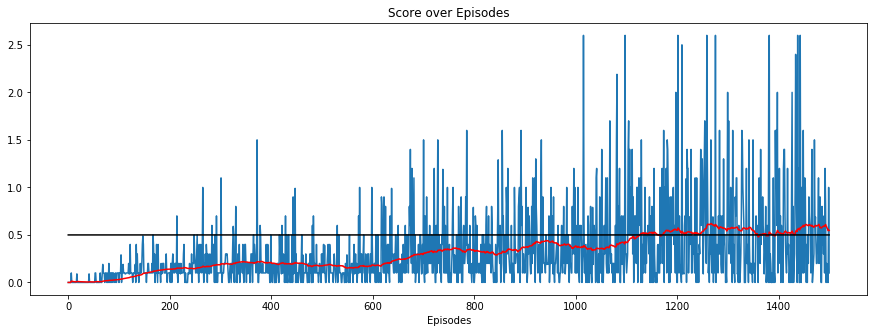

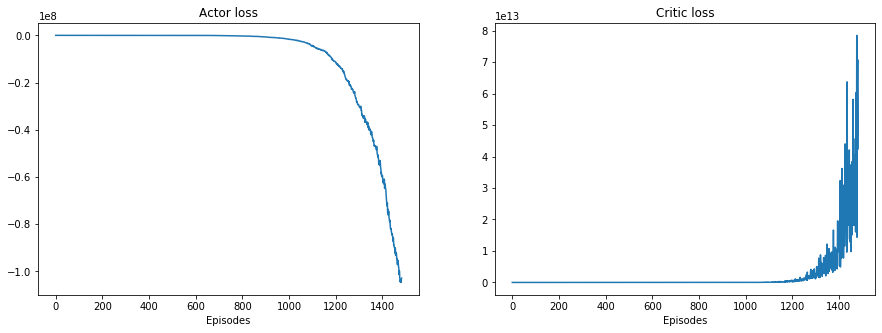

In [5]:
nr_episodes = 1500
for i in range(20):
    seed = np.random.randint(10000000)
    ACloss, rolling_avg, e_score, agent = train_agent(env, nr_episodes, num_agents, seed)
    if rolling_avg.max() > 0.5:
        plt.figure(figsize=(15,5))
        plt.plot(e_score)
        plt.plot(rolling_avg,'r')
        plt.plot(0.5*np.ones_like(rolling_avg),'k')
        plt.title('Score over Episodes')
        plt.xlabel('Episodes')
        plt.savefig('Scores.png')
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(ACloss[:,0])
        plt.title('Actor loss')
        plt.xlabel('Episodes')
        plt.subplot(122)
        plt.plot(ACloss[:,1])
        plt.title('Critic loss')
        plt.xlabel('Episodes')
        plt.savefig('AC_loss.png')
        print('Tennis solved!')
        break

Text(0.5, 0, 'Episodes')

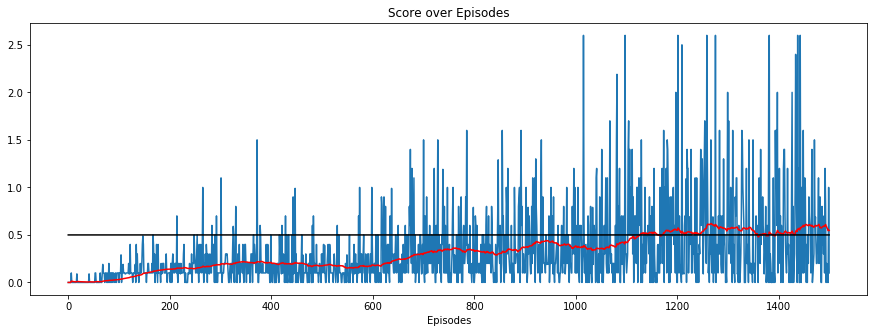

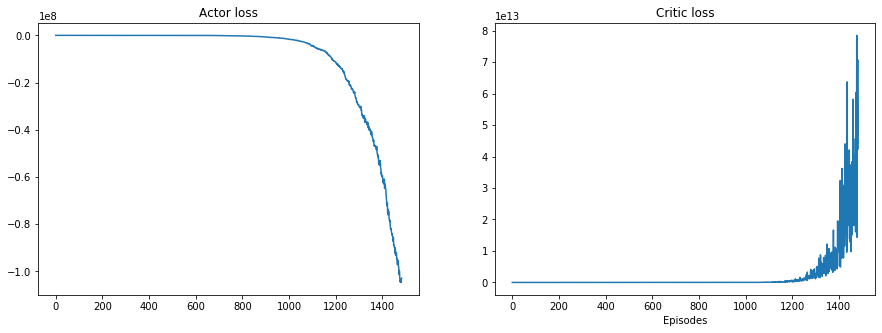

In [6]:
plt.figure(figsize=(15,5))
plt.plot(e_score)
plt.plot(rolling_avg,'r')
plt.plot(0.5*np.ones_like(rolling_avg),'k')
plt.title('Score over Episodes')
plt.xlabel('Episodes')
# plt.savefig('Scores.png')
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ACloss[:,0])
plt.title('Actor loss')
plt.subplot(122)
plt.plot(ACloss[:,1])
plt.title('Critic loss')
plt.xlabel('Episodes')
# plt.savefig('AC_loss.png')

lra 0.0005, lrc 0.0005, noise_lvl 0.2, noise_decay 1, batch_size 128, update_steps 1, GD_steps 2 => 0.25

In [7]:
# agent.actor.eval()
# for i in range(5):                                         # play game for nr_episodes episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     ou.reset()
#     while True:#t<T_max:
#         t+=1
#         # select action
#         noise = ou.noise()
#         actA  = agent.act(states[np.newaxis,0]).data.cpu().numpy() + noise[0]
#         actB = agent.act(states[np.newaxis,1]).data.cpu().numpy() + noise[1]
#         actions = np.clip([actA[0], actB[0]],-1,1) # select an action (for each agent)
#         # execute and observe
#         #actions = [np.array([0.1,1]),np.array([0.1,1])]
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         # roll over states to next time step
#         states = next_states                               
#         # keep track of scores
#         scores += env_info.rewards                         # update the score (for each agent)
#         # exit loop if episode finished
#         if np.any(dones): 
#             break
#     print('Best player score in episode {}: {}'.format(i,np.max(scores)))

In [8]:
# env.close()